# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: \<Süleyman Yolcu\>
## Student ID: \<2210765016\>


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a spefisific algorithm to handle outliers for example. But **show your work!**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_dataset = 'Mall_Customers.csv'
df = pd.read_csv(path_to_dataset)

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


- Gender column is categorical

In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- There is no null value in the dataset

In [5]:
df.drop(columns='CustomerID',inplace=True)

 - Customer ID does not provide any useful information for this assignment. So I dropped it

In [6]:
dummies = pd.get_dummies(df['Gender'],prefix='Gender')
df = pd.concat([df,dummies],axis=1).drop(columns=['Gender'])

- Also Gender column is encoded

In [7]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,False,True
1,21,15,81,False,True
2,20,16,6,True,False
3,23,16,77,True,False
4,31,17,40,True,False


In [8]:
df.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

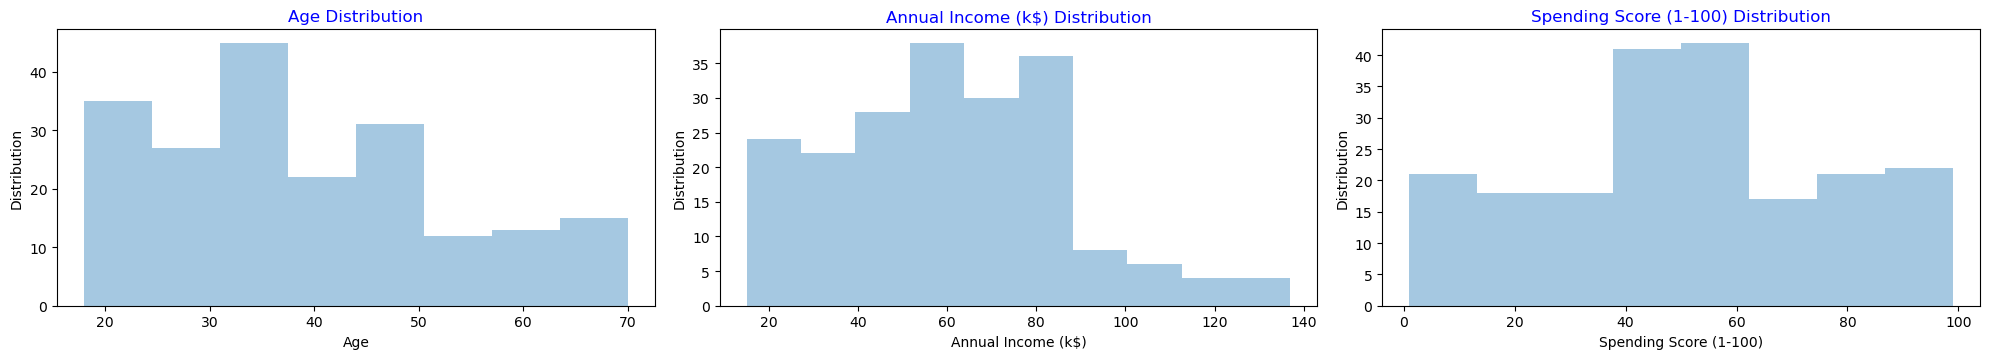

In [9]:
f=plt.figure(figsize=(20,20))
for i, col in enumerate(['Age','Annual Income (k$)','Spending Score (1-100)']):
    ax=f.add_subplot(6,3,i+1)
    sns.distplot(df[col].ffill(),kde=False)
    ax.set_title(col+" Distribution",color='Blue')
    plt.ylabel('Distribution')
f.tight_layout()

- Data visulatization

### Outlier Handling

In [10]:
numeric_features = df[['Age','Annual Income (k$)','Spending Score (1-100)']]

# Calculate quartiles and IQR for each numerical feature
Q1 = numeric_features.quantile(0.25)
Q3 = numeric_features.quantile(0.75)
IQR = Q3 - Q1

# Set a threshold for defining outliers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Initialize an empty list to store outlier information
outlier_info = []

# Iterate through numerical features to identify and store outliers
for feature in numeric_features.columns:
    upper_whisker_point = df[df[feature] > upper_whisker[feature]][feature]
    lower_whisker_point = df[df[feature] < lower_whisker[feature]][feature]
    
    outliers = pd.concat([lower_whisker_point, upper_whisker_point])

    # Append outlier information as a dictionary to the list
    outlier_info.append({'Feature': feature, 'Lower_Whisker': lower_whisker[feature],
                         'Upper_Whisker': upper_whisker[feature], 'Outliers': outliers.tolist()})



# Convert the list of dictionaries to a DataFrame
outlier_info = pd.DataFrame(outlier_info)
outlier_info['Total Outlier Number '] = outlier_info['Outliers'].apply(lambda x: len(x))
display(outlier_info)

,Feature,Lower_Whisker,Upper_Whisker,Outliers,Total Outlier Number
0,Age,-1.625,79.375,[],0
1,Annual Income (k$),-13.250,132.750,"[137, 137]",2
2,Spending Score (1-100),-22.625,130.375,[],0


- I used IQR method for detecting outliers 
- There are two outliers at the end of the data set which caused by Annucal Income values are 137

In [11]:
for feature in numeric_features:
    outliers = outlier_info[outlier_info['Feature'] == feature]['Outliers'].values[0]
    mean_value = df[feature].mean()
    median_value = df[feature].median()
    df.loc[df[feature].isin(outliers), feature] = median_value

- Outliers are imputed with median value because the data is numerical and median is robust against outlier values.

## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

In [12]:
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

min_max_scaler = MinMaxScaler()
df_normalized = min_max_scaler.fit_transform(df)

- The data is normalized and standardized 

## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

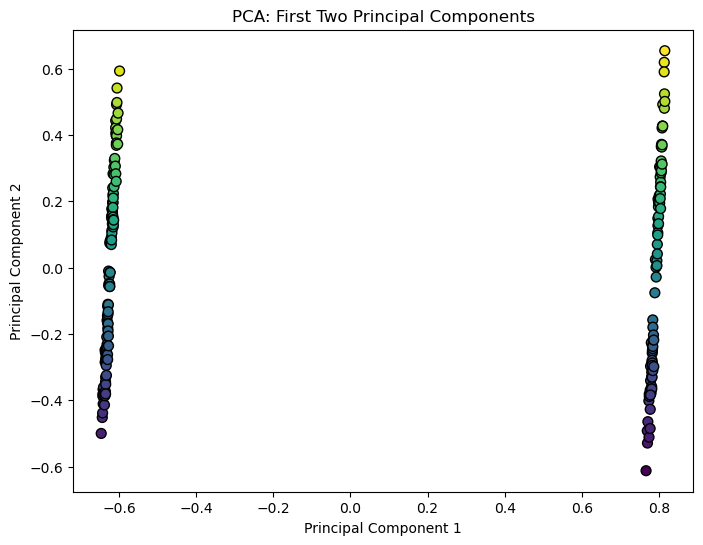

In [13]:
# Apply PCA to the normalized data
pca = PCA()
df_pca = pca.fit_transform(df_normalized)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Visualize the data with the first two principal components as axes
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c =df_pca[:, 1],cmap='viridis', edgecolor='k', s=50)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

- From the scatter plot above we can clearly see that two clusters are formed

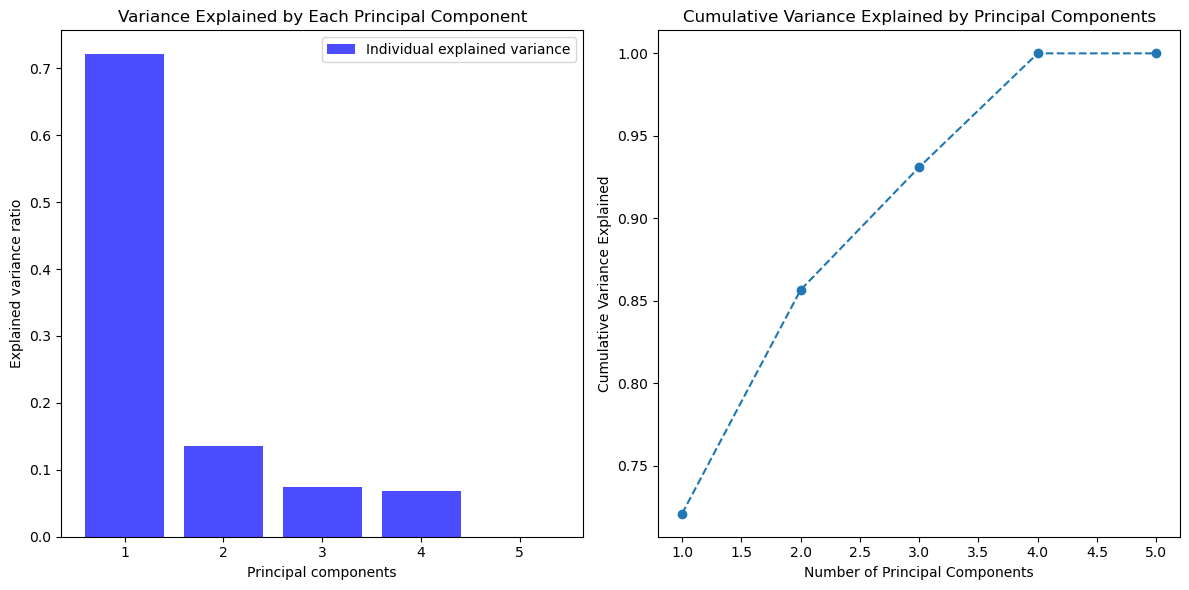

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')

plt.subplot(1, 2, 1)
plt.bar(range(1, len(cumulative_explained_variance) + 1), explained_variance_ratio, alpha=0.7, color='blue', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()

- From the first graph above it seems the first principal component has the highest contribution
- From the second graph above it seems that 4 principal components has the highest cumulative variance and also since we encoded the gender column the second column that indicates the males does not provide any useful info

### ** If we choose the threshold as %85 variance, we should choose 2 principal components
### ** 2 principal components explains the data sufficently


## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

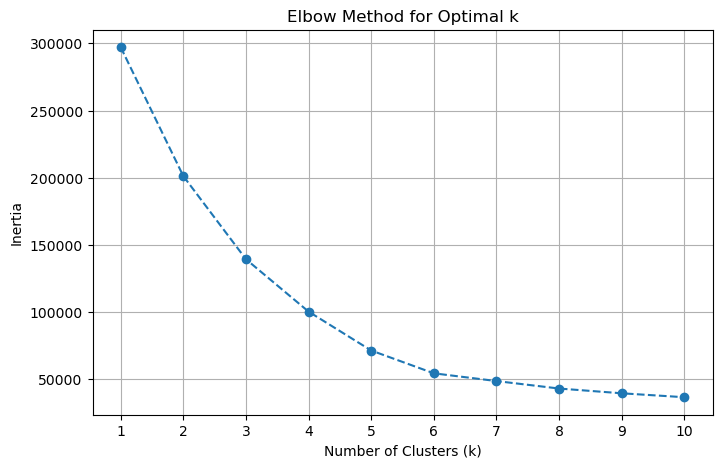

In [15]:
# Use the Elbow method to find the optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

- Although it is not clearly seen, elbow point is most likely at point 6. So we should choose the number of clusters as 6.

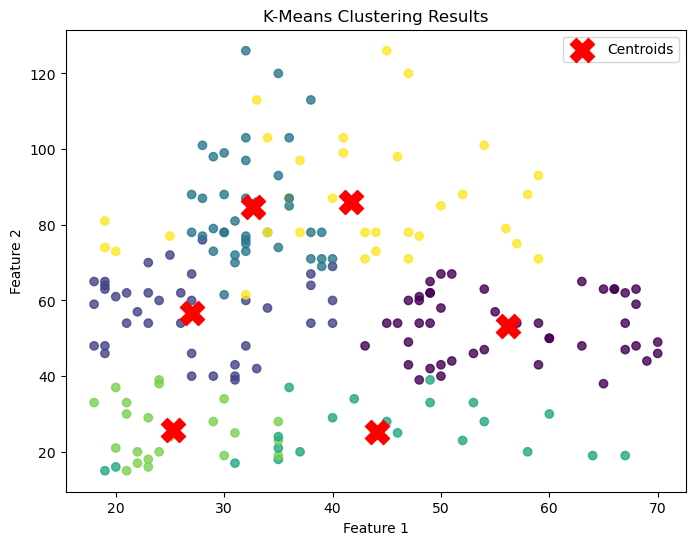

In [16]:
optimal_k = 6 

# Apply K-Means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(df)

# Visualize the resulting clusters 
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

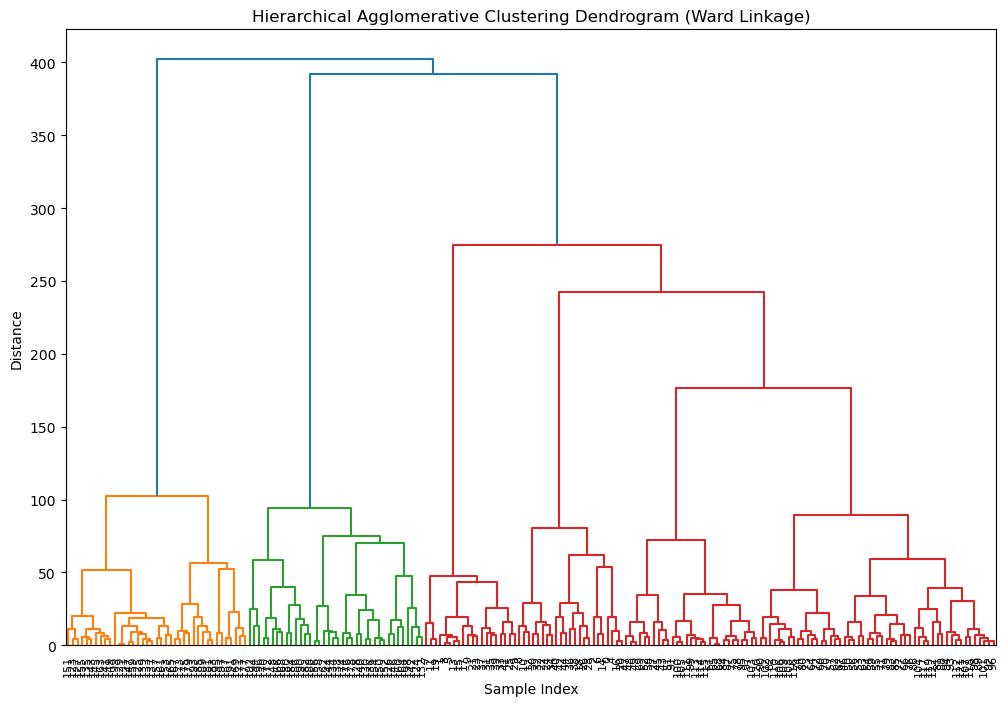

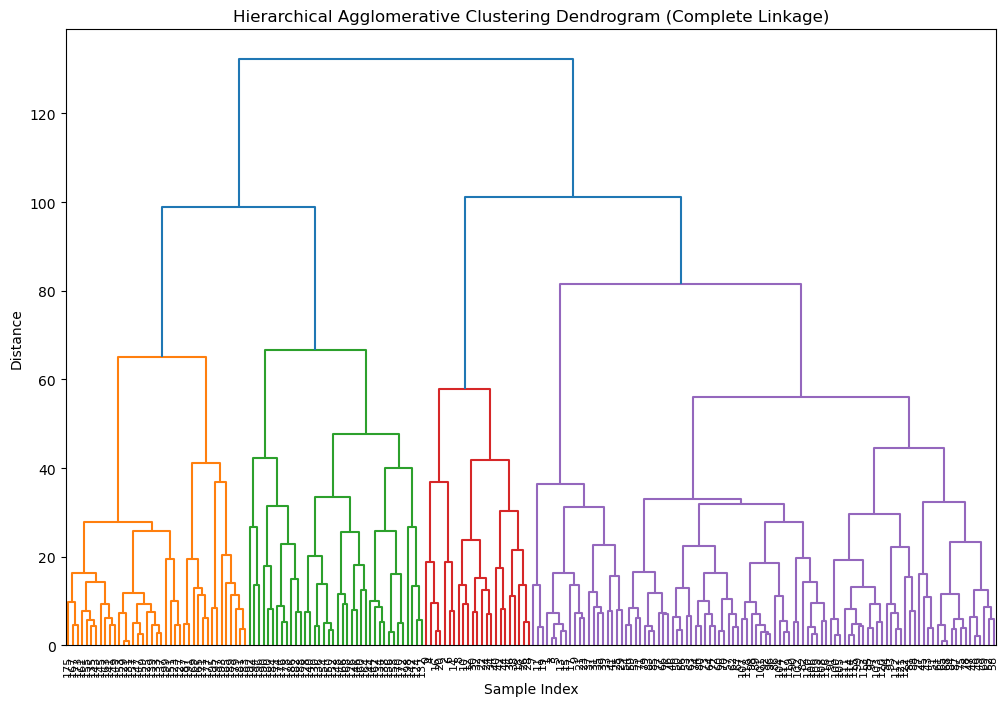

In [17]:
# Apply HAC with 'ward' linkage
linkage_method_ward = linkage(df, method='ward')

# Visualize the dendrogram for 'ward' linkage
plt.figure(figsize=(12, 8))
dendrogram(linkage_method_ward, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Agglomerative Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Apply HAC with 'complete' linkage
linkage_method_complete = linkage(df, method='complete')

# Visualize the dendrogram for 'complete' linkage
plt.figure(figsize=(12, 8))
dendrogram(linkage_method_complete, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Agglomerative Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

- If we choose a height cutoff between distances 100-150 for the ward linkage we can see that 6 clusters are formed


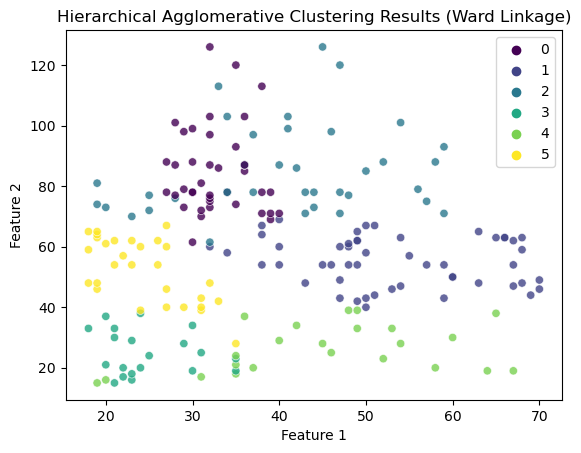

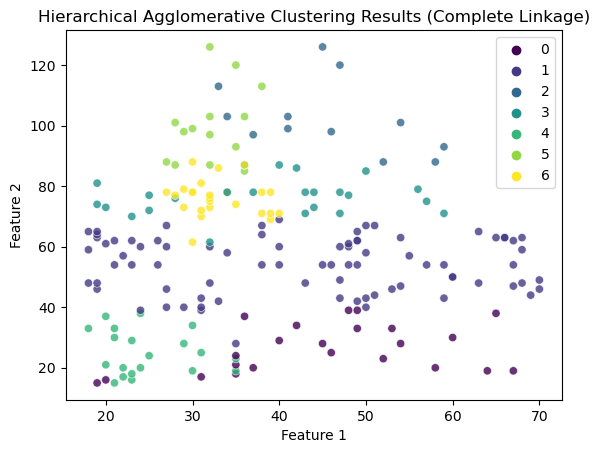

In [18]:
# We can visually inspect the dendrogram and set a suitable height cutoff
hac_complete = AgglomerativeClustering(n_clusters=7, linkage='complete')
clusters_hac_complete = hac_complete.fit_predict(df)

hac_ward = AgglomerativeClustering(n_clusters=6, linkage='ward')
clusters_hac_ward = hac_ward.fit_predict(df)


sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=clusters_hac_ward, palette='viridis', alpha=0.8)
plt.title('Hierarchical Agglomerative Clustering Results (Ward Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=clusters_hac_complete, palette='viridis', alpha=0.8)
plt.title('Hierarchical Agglomerative Clustering Results (Complete Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

- HAC results for the ward linkage agrees with the clusters obtained by K-Means using the elbow method

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

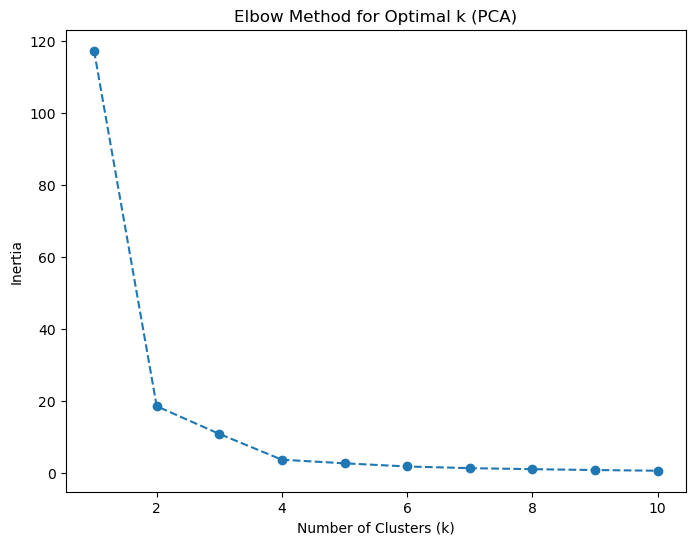

In [19]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)

inertia_pca = []
for k in range(1, 11):
    kmeans_pca = KMeans(n_clusters=k, random_state=0)
    kmeans_pca.fit(df_pca)
    inertia_pca.append(kmeans_pca.inertia_)

# Plot the Elbow curve for PCA
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_pca, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

- We can clearly see that the elbow point is at two. So we should choose k = 2 clusters as optimal.

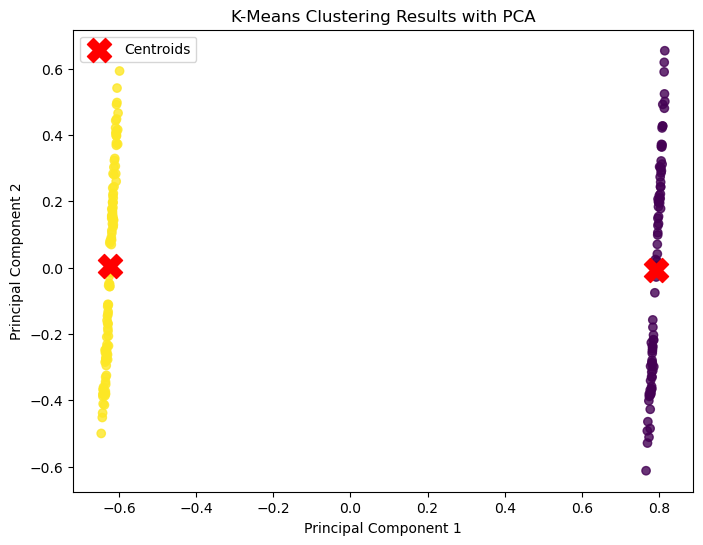

In [20]:
optimal_k_pca = 2  # Based on the Elbow plot

# Apply K-Means clustering with the optimal k on PCA-transformed data
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=0)
clusters_pca = kmeans_pca.fit_predict(df_pca)

# Visualize the resulting clusters in the PCA space
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_pca, cmap='viridis', alpha=0.8)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering Results with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [21]:
silhouette_score_original = silhouette_score(df, clusters, random_state=0)
silhouette_score_pca = silhouette_score(df_pca, clusters_pca, random_state=0)


print(f"Silhouette Coefficient without PCA: {silhouette_score_original}")
print(f"Silhouette Coefficient with PCA: {silhouette_score_pca}")


Silhouette Coefficient without PCA: 0.4555592280144017
Silhouette Coefficient with PCA: 0.7625029287638192


#### Silhouette Coefficent

- The Silhouette Coefficient is a measure of how well-defined clusters are within the data. It ranges from -1 to 1, where a high value indicates well-defined clusters, a value near 0 indicates overlapping clusters, and negative values indicate that data points might have been assigned to the wrong cluster.

#### Comparison

- A higher Silhouette Coefficient generally indicates better-defined clusters. Therefore, in this comparison, the clustering results with PCA (0.76) are better than the results without PCA (0.45). The higher Silhouette Coefficient with PCA suggests that the clusters are more distinct and well-separated after applying principal component analysis. This could mean that the dimensionality reduction provided by PCA helped improve the clustering performance.